In [7]:
#!pip install pandas numpy tensorflow keras
#!pip install --upgrade pandas
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load datasets
#Updated to try except block to handle older version of pandas
try:
    train_df = pd.read_csv('/content/train.csv', quoting=pd.QUOTE_NONNUMERIC, on_bad_lines='skip')
    test_df = pd.read_csv('/content/test.csv', quoting=pd.QUOTE_NONNUMERIC, on_bad_lines='skip')
except AttributeError:
    train_df = pd.read_csv('/content/train.csv', on_bad_lines='skip')  # For pandas versions < 1.0
    test_df = pd.read_csv('/content/test.csv', on_bad_lines='skip')  # For pandas versions < 1.0

# Extract texts and titles
train_texts = train_df['text'].astype(str).tolist()
train_titles = train_df['title'].astype(str).tolist()
test_texts = test_df['text'].astype(str).tolist()
test_titles = test_df['title'].astype(str).tolist()

# ... (rest of your code)

# Extract texts and titles
train_texts = train_df['text'].astype(str).tolist()
train_titles = train_df['title'].astype(str).tolist()
test_texts = test_df['text'].astype(str).tolist()
test_titles = test_df['title'].astype(str).tolist()

# Add <start> and <end> tokens to titles for sequence-to-sequence learning
#train_titles = ['<start> ' + title + ' <end>' for title in train_titles]
#test_titles = ['<start> ' + title + ' <end>' for title in test_titles]

# Tokenization parameters
vocab_size = 20000
max_text_len = 400
max_title_len = 20  # include <start> and <end> tokens within this length


# Tokenizer for texts
text_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
text_tokenizer.fit_on_texts(train_texts)
train_text_seq = text_tokenizer.texts_to_sequences(train_texts)
train_text_seq = pad_sequences(train_text_seq, maxlen=max_text_len, padding='post')
test_text_seq = text_tokenizer.texts_to_sequences(test_texts)
test_text_seq = pad_sequences(test_text_seq, maxlen=max_text_len, padding='post')

# Tokenizer for titles
title_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>', filters='')
title_tokenizer.fit_on_texts(train_titles)
train_title_seq = title_tokenizer.texts_to_sequences(train_titles)
train_title_seq = pad_sequences(train_title_seq, maxlen=max_title_len, padding='post')
test_title_seq = title_tokenizer.texts_to_sequences(test_titles)
test_title_seq = pad_sequences(test_title_seq, maxlen=max_title_len, padding='post')

# Prepare decoder input and output sequences
decoder_input_seq = train_title_seq[:, :-1]
decoder_target_seq = train_title_seq[:, 1:]

# Prepare decoder input for test set (used in evaluation and later generation)
decoder_input_test_seq = test_title_seq[:, :-1]
decoder_target_test_seq = test_title_seq[:, 1:]


In [35]:
import time
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from nltk.translate.bleu_score import sentence_bleu
import nltk
nltk.download('punkt')

# Model parameters
embedding_dim = 256
lstm_units = 512

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# Decoder
decoder_inputs = Input(shape=(max_title_len - 1,))
dec_emb_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model_no_attention = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_no_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_no_attention.summary()

# Train the model
start_time = time.time()
model_no_attention.fit([train_text_seq, decoder_input_seq], decoder_target_seq, batch_size=100, epochs=30, validation_split=0.2)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Evaluate BLEU Score
def evaluate_bleu(model, inputs, targets, tokenizer):
    predictions = model.predict(inputs)
    predicted_ids = np.argmax(predictions, axis=-1)
    references = [[tokenizer.index_word.get(id, '') for id in target if id != 0] for target in targets]
    hypotheses = [[tokenizer.index_word.get(id, '') for id in pred if id != 0] for pred in predicted_ids]
    scores = [sentence_bleu([ref], hyp) for ref, hyp in zip(references, hypotheses)]
    return np.mean(scores)

# Inference time measurement
start_inf_time = time.time()
_ = model_no_attention.predict([test_text_seq[:1], test_title_seq[:, :-1][:1]])
inference_time = time.time() - start_inf_time
print(f"Inference time per sample: {inference_time:.4f} seconds")

# BLEU score
bleu_score_no_attention = evaluate_bleu(model_no_attention, [test_text_seq, test_title_seq[:, :-1]], test_title_seq[:, 1:], title_tokenizer)
print(f"BLEU Score on Test Set: {bleu_score_no_attention:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 400, 256)  │  5,120,000 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 400)       │          0 │ input_layer_9[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 19, 256)   │  5,120,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 512),     │  1,574,912 │ embedding_4[0][0… │
│                     │ (None, 512),      │            │ not_equal_2[0][0] │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 19, 512), │  1,574,912 │ embedding_5[0][0… │
│                     │ (None, 512),      │            │ lstm_2[0][1],     │
│                     │ (None, 512)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 19, 20000) │ 10,260,000 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,649,824 (90.22 MB)

 Trainable params: 23,649,824 (90.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 295ms/step - accuracy: 0.4863 - loss: 8.1839 - val_accuracy: 0.5426 - val_loss: 7.1416
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 278ms/step - accuracy: 0.5442 - loss: 6.8908 - val_accuracy: 0.5480 - val_loss: 6.9997
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 34s 284ms/step - accuracy: 0.5509 - loss: 6.5935 - val_accuracy: 0.5529 - val_loss: 6.8857
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 35s 289ms/step - accuracy: 0.5581 - loss: 6.3260 - val_accuracy: 0.5561 - val_loss: 6.8003
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 308ms/step - accuracy: 0.5661 - loss: 6.0329 - val_accuracy: 0.5601 - val_loss: 6.7335
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 315ms/step - accuracy: 0.5747 - loss: 5.7429 - val_accuracy: 0.5649 - val_loss: 6.7034
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.5846 - loss: 5.4550 - val_accuracy: 0.5672 - val_loss: 6.6867
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 316ms/step - accuracy: 0.5921 - loss: 5

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
import numpy as np

# Positional Encoding
def get_positional_encoding(max_len, dm):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(dm)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(dm))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

# Multi-head Attention block
# Multi-head Attention block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False, mask=None): # Set a default value for training
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define Encoder
def build_encoder(vocab_size, max_len, embed_dim, num_heads, ff_dim):
    inputs = Input(shape=(max_len,))
    x = Embedding(vocab_size, embed_dim)(inputs)
    x += get_positional_encoding(max_len, embed_dim)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    return Model(inputs, x, name='Encoder')

# Define Decoder
def build_decoder(vocab_size, max_len, embed_dim, num_heads, ff_dim):
    inputs = Input(shape=(max_len,))
    enc_output = Input(shape=(None, embed_dim))
    x = Embedding(vocab_size, embed_dim)(inputs)
    x += get_positional_encoding(max_len, embed_dim)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, enc_output)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(vocab_size, activation='softmax')(x)
    return Model([inputs, enc_output], outputs, name='Decoder')

# Hyperparameters
embed_dim = 256
num_heads = 4
ff_dim = 512
max_text_len = 400
max_title_len = 20
vocab_size = 20000

# Instantiate encoder and decoder
encoder = build_encoder(vocab_size, max_text_len, embed_dim, num_heads, ff_dim)
decoder = build_decoder(vocab_size, max_title_len - 1, embed_dim, num_heads, ff_dim)

# Define final model
encoder_inputs = Input(shape=(max_text_len,))
decoder_inputs = Input(shape=(max_title_len - 1,))
enc_out = encoder(encoder_inputs)
dec_out = decoder([decoder_inputs, enc_out])
model_transformer = Model([encoder_inputs, decoder_inputs], dec_out)
model_transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_transformer.summary()

# For training
model_transformer.fit([train_text_seq, decoder_input_seq], decoder_target_seq, batch_size=64, epochs=20, validation_split=0.2)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 400, 256)  │  6,435,840 │ input_layer_7[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 19, 20000) │ 12,628,256 │ input_layer_8[0]… │
│ (Functional)        │                   │            │ Encoder[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,064,096 (72.72 MB)

 Trainable params: 19,064,096 (72.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 318ms/step - accuracy: 0.5127 - loss: 5.2826 - val_accuracy: 0.5275 - val_loss: 3.9185
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - accuracy: 0.5285 - loss: 3.8755 - val_accuracy: 0.5275 - val_loss: 3.9383
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 229ms/step - accuracy: 0.5283 - loss: 3.8345 - val_accuracy: 0.5275 - val_loss: 3.9516
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 229ms/step - accuracy: 0.5288 - loss: 3.8202 - val_accuracy: 0.5275 - val_loss: 3.9600
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 222ms/step - accuracy: 0.5269 - loss: 3.8315 - val_accuracy: 0.5275 - val_loss: 3.9682
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 228ms/step - accuracy: 0.5292 - loss: 3.8136 - val_accuracy: 0.5275 - val_loss: 3.9735
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 219ms/step - accuracy: 0.5284 - loss: 3.8198 - val_accuracy: 0.5275 - val_loss: 3.9800
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 232ms/step - accuracy: 0.5277 - loss: 3

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Assuming other necessary imports like numpy are already present

# --- Model Definition: Encoder-Decoder with Attention ---

# Encoder
encoder_inputs = Input(shape=(max_text_len,), name='encoder_inputs')
# Ensure embedding_dim and vocab_size are defined earlier in your notebook
enc_emb = Embedding(vocab_size, embedding_dim, name='encoder_embedding')(encoder_inputs)
# Encoder LSTM outputs sequences for attention and states for decoder initialization
# Use lstm_units here as defined in your code
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
# Decoder input is the target sequence shifted by one position
decoder_inputs = Input(shape=(max_title_len - 1,), name='decoder_inputs')
# Ensure max_title_len is defined earlier
# Decoder embedding layer
# Use the same embedding_dim and vocab_size
dec_emb_layer = Embedding(vocab_size, embedding_dim, name='decoder_embedding')
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM, returns sequences for attention and states for inference
# Use lstm_units here as defined in your code
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Attention Layer
# Computes attention weights and applies them
attention_layer = Attention(name='attention_layer')
attention_output = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate decoder outputs and attention output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_output])

# Dense layer to predict the next token
# Use vocab_size for the output layer size
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output_dense')
final_decoder_outputs = decoder_dense(decoder_concat_input)

# Define the final model
model_with_attention = Model([encoder_inputs, decoder_inputs], final_decoder_outputs)

# Compile the model
# Using Adam optimizer and sparse categorical crossentropy loss
model_with_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print("--- Model with Attention Summary ---")
model_with_attention.summary()

--- Model with Attention Summary ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 400, 256)  │  5,120,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 19, 256)   │  5,120,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 400,      │  1,574,912 │ encoder_embeddin… │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 19, 512), │  1,574,912 │ decoder_embeddin… │
│                     │ (None, 512),      │            │ encoder_lstm[0][… │
│                     │ (None, 512)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 19, 512)   │          0 │ decoder_lstm[0][… │
│ (Attention)         │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 19, 1024)  │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_den… │ (None, 19, 20000) │ 20,500,000 │ concat_layer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,889,824 (129.28 MB)

 Trainable params: 33,889,824 (129.28 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_with_attention.fit(
    [train_text_seq, decoder_input_seq],
    decoder_target_seq,
    batch_size=64,
    epochs=15,
    validation_split=0.2
)

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 63s 323ms/step - accuracy: 0.5189 - loss: 4.7317 - val_accuracy: 0.5433 - val_loss: 3.7524
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 320ms/step - accuracy: 0.5470 - loss: 3.5872 - val_accuracy: 0.5513 - val_loss: 3.6335
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 321ms/step - accuracy: 0.5541 - loss: 3.3779 - val_accuracy: 0.5564 - val_loss: 3.5502
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 318ms/step - accuracy: 0.5649 - loss: 3.1280 - val_accuracy: 0.5649 - val_loss: 3.4761
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 324ms/step - accuracy: 0.5785 - loss: 2.8685 - val_accuracy: 0.5730 - val_loss: 3.4050
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 321ms/step - accuracy: 0.5922 - loss: 2.5752 - val_accuracy: 0.5738 - val_loss: 3.3848
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 319ms/step - accuracy: 0.6084 - loss: 2.2993 - val_accuracy: 0.5796 - val_loss: 3.3981
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 325ms/step - accuracy: 0.6315 - loss: 2

In [9]:
test_df = pd.read_csv('/content/test.csv')

# Extract texts and titles
test_texts = test_df['text'].astype(str).tolist()
test_titles = test_df['title'].astype(str).tolist()

# Preprocess test data for both models
test_text_seq = text_tokenizer.texts_to_sequences(test_texts)
test_text_seq = pad_sequences(test_text_seq, maxlen=max_text_len, padding='post')

# Prepare decoder input sequences for model_no_attention
test_title_seq = title_tokenizer.texts_to_sequences(test_titles)
test_title_seq = pad_sequences(test_title_seq, maxlen=max_title_len, padding='post')
decoder_input_test_seq = test_title_seq[:, :-1]

# Evaluate model_no_attention
loss_no_att, acc_no_att = model_no_attention.evaluate([test_text_seq, decoder_input_test_seq], test_title_seq[:, 1:], verbose=0)
print(f"Model Without Attention - Loss: {loss_no_att}, Accuracy: {acc_no_att}")

# Prepare target sequences for model_self_attention
test_title_seq_flat = np.array([seq[0] if len(seq) > 0 else 0 for seq in test_title_seq])

# Evaluate model_self_attention
# Evaluate model_transformer (renamed from model_self_attention)
loss_self_att, acc_self_att = model_transformer.evaluate([test_text_seq, decoder_input_test_seq], test_title_seq[:, 1:], verbose=0) # Use model_transformer and correct input format
print(f"Model With Self-Attention - Loss: {loss_self_att}, Accuracy: {acc_self_att}")


# Evaluate model_with_attention
loss_with_att, acc_with_att = model_with_attention.evaluate([test_text_seq, decoder_input_test_seq], test_title_seq[:, 1:], verbose=0)
print(f"Model With Attention - Loss: {loss_with_att}, Accuracy: {acc_with_att}")

Model Without Attention - Loss: 2.8694217205047607, Accuracy: 0.7836257815361023
Model With Self-Attention - Loss: 3.8176803588867188, Accuracy: 0.5321637988090515
Model With Attention - Loss: 1.6158041954040527, Accuracy: 0.7426900267601013


In [19]:
def generate_headline(text_input, model, max_title_len=20):
    # Tokenize and pad the input text
    seq = text_tokenizer.texts_to_sequences([text_input])
    seq = pad_sequences(seq, maxlen=max_text_len, padding='post')

    # Start the decoder with the <start> token
    start_token = title_tokenizer.word_index.get('<start>', 1)  # Use 1 if <start> not defined
    end_token = title_tokenizer.word_index.get('<end>', 2)      # Use 2 if <end> not defined
    output_seq = [start_token]

    for i in range(max_title_len - 1):
        # Pad decoder input
        dec_input = pad_sequences([output_seq], maxlen=max_title_len - 1, padding='post')
        # Predict next word
        preds = model.predict([seq, dec_input], verbose=0)
        next_word_id = np.argmax(preds[0, i])
        output_seq.append(next_word_id)

        if next_word_id == end_token:
            break

    # Convert token IDs back to words
    inverse_title_index = {v: k for k, v in title_tokenizer.word_index.items()}
    words = [inverse_title_index.get(i, '') for i in output_seq if i not in [0, start_token, end_token]]
    return ' '.join(words)

# Example usage
custom_text = " U.S. President Donald Trump faces an uphill battle to overcome a federal judgeâ€™s temporary hold on his travel ban on seven mainly Muslim countries, but the outcome of a ruling on the executive orderâ€™s ultimate legality is less certain.  Any appeals of decisions by U.S. District Court Judge James Robart in Seattle face a regional court dominated by liberal-leaning judges who might not be sympathetic to Trumpâ€™s rationale for the ban, and a currently shorthanded Supreme Court split 4-4 between liberals and conservatives. The temporary restraining order Robart issued on Friday in Seattle, which applies nationwide, gives him time to consider the case in more detail, but also sends a signal that he is likely to impose a more permanent injunction.    The Trump administration has appealed that order. The San Francisco-based 9th U.S. Circuit Court of Appeals said late on Saturday that it would not decide whether to lift the judgeâ€™s ruling, as requested by the U.S. government, until it receives briefs from both sides, with the administrationâ€™s filing due on Monday. Appeals courts are generally leery of upending the status quo, which in this case - for now - is the suspension of the ban.  The upheaval prompted by the new Republican administrationâ€™s initial announcement of the ban on Jan. 27, with travelers detained at airports upon entering the country, would potentially be kickstarted again if Robartâ€™s stay was lifted. The appeals court might also take into account the fact that there are several other cases around the country challenging the ban. If it were to overturn the district courtâ€™s decision, another judge somewhere else in the United States could impose a new order, setting off a new cascade of court filings.  If the appeals court upholds the order, the administration could immediately ask the U.S. Supreme Court to intervene. But the high court is generally reluctant to get involved in cases at a preliminary stage, legal experts said. The high court is short one justice, as it has been for a year, leaving it split between liberals and conservatives. Any emergency request by the administration would need five votes to be granted, meaning at least one of the liberals would have to vote in favor.  â€œI think the courtâ€™s going to feel every reason to stay on the sidelines as long as possible,â€ said Steve Vladeck, a professor at the University of Texas School of Law. Trump last week nominated a conservative appeals court judge, Neil Gorsuch, to fill the vacancy, but he will not be sitting on the Supreme Court for at least two months. Gorsuchâ€™s vote, if he is confirmed by the U.S. Senate, could come into play if the case were to reach the court at a later stage of the litigation. Once the case proceeds past the injunction stage of the litigation and onto the merits of whether the order is legally sound, legal experts differ over how strong the governmentâ€™s case would be.  Richard Primus, a professor of constitutional law at the University of Michigan Law School, said the administration could struggle to convince courts that the ban was justified by national security concerns.  The Supreme Court has previously rejected the idea that the government does not need to offer a basis for its actions in the national security context, including the landmark 1971 Pentagon Papers case, in which the administration of President Richard Nixon tried unsuccessfully to prevent the press from publishing information about United States policy toward Vietnam. â€œThe governmentâ€™s argument so far in support of the order is pretty weak,â€ Primus said. Jonathan Adler, a professor at Case Western Reserve University School of Law, said the administration has legal precedent on its side, with the courts generally deferential to executive action on immigration.  However, he said it is unusual for the courts to be asked to endorse â€œa policy that appears to have been adopted in as kind of haphazard and arbitrary way as this one appears to have been."
generated_headline = generate_headline(custom_text, model_with_attention)
print("Generated Headline:", generated_headline)


Generated Headline: faces uphill battle against trump supreme court nominee


In [40]:
def generate_headline_no_attention(text_input, model, max_title_len=20):
    # Tokenize and pad the input text
    seq = text_tokenizer.texts_to_sequences([text_input])
    seq = pad_sequences(seq, maxlen=max_text_len, padding='post')

    # Start the decoder with the <start> token
    start_token = title_tokenizer.word_index.get('<start>', 1)  # Use 1 if <start> not defined
    end_token = title_tokenizer.word_index.get('<end>', 2)      # Use 2 if <end> not defined
    output_seq = [start_token]

    for i in range(max_title_len - 1):
        # Pad decoder input
        dec_input = pad_sequences([output_seq], maxlen=max_title_len - 1, padding='post')
        # Predict next word
        preds = model.predict([seq, dec_input], verbose=0)
        next_word_id = np.argmax(preds[0, i])
        output_seq.append(next_word_id)

        if next_word_id == end_token:
            break

    # Convert token IDs back to words
    inverse_title_index = {v: k for k, v in title_tokenizer.word_index.items()}
    words = [inverse_title_index.get(i, '') for i in output_seq if i not in [0, start_token, end_token]]
    return ' '.join(words)

# Example usage
custom_text = "a usfunded famine survey said on tuesday that thousands of yemenis could die daily if a saudiled military coalition does not lift its blockade on the country s key ports the warning came a day after the international committee of the red cross icrc said  million people in yemen s crowded cities had no access to clean water raising the risk that a cholera epidemic will spread using the internationally recognized ipc  scale for classifying food security the famine early warning systems network fews net said that even before the current blockade  million people were in  crisis  ipc phase  or worse  therefore a prolonged closure of key ports risks an unprecedented deterioration in food security to famine ipc phase  across large areas of the country  it said  it said famine is likely in many areas within three or four months if ports remain closed with some less accessible areas at even greater risk in such a scenario shortages of food and fuel would drive up prices and a lack of medical supplies would exacerbate lifethreatening diseases  thousands of deaths would occur each day due to the lack of food and disease outbreaks  said fews net which is funded by the us agency for international development  famine remained likely even if the southern port of aden is open its report said adding that all yemeni ports should be reopened to essential imports the united nations has said the saudiled coalition must allow aid in through hodeidah port controlled by the houthis the saudis  enemies in the war in yemen  un humanitarian agencies have issued dire warnings about the impact of the blockade although un officials have declined to directly criticize saudi arabia jan egeland head of the norwegian refugee council and a former un aid chief was blunt in his criticism however  us uk  other allies of saudi has only weeks to avoid being complicit in a famine of biblical proportions lift the blockade now  he wrote in a tweet   last year saudi arabia was accused by then un secretary general ban kimoon of exerting  unacceptable  undue pressure to keep itself off a blacklist of countries that kill children in conflict after sources told reuters that riyadh had threatened to cut some un funding saudi arabia denied this."
generated_headline = generate_headline_no_attention(custom_text, model_no_attention)  # Pass model_no_attention here
print("Generated Headline:", generated_headline)

Generated Headline: humanitarian situation falls under return


In [45]:
!pip install nltk rouge-score

In [46]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

In [48]:
def calculate_bleu(model, inputs, targets, tokenizer):
    predictions = model.predict(inputs)
    predicted_ids = np.argmax(predictions, axis=-1)
    references = [[tokenizer.index_word.get(id, '') for id in target if id != 0] for target in targets]
    hypotheses = [[tokenizer.index_word.get(id, '') for id in pred if id != 0] for pred in predicted_ids]
    scores = [sentence_bleu([ref], hyp) for ref, hyp in zip(references, hypotheses)]
    return np.mean(scores)

def calculate_rouge(model, inputs, targets, tokenizer):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    predictions = model.predict(inputs)
    predicted_ids = np.argmax(predictions, axis=-1)
    references = [' '.join([tokenizer.index_word.get(id, '') for id in target if id != 0]) for target in targets]
    hypotheses = [' '.join([tokenizer.index_word.get(id, '') for id in pred if id != 0]) for pred in predicted_ids]
    scores = [scorer.score(ref, hyp)['rouge1'].fmeasure for ref, hyp in zip(references, hypotheses)]
    return np.mean(scores)

In [50]:
# For model_no_attention
bleu_score_no_attention = calculate_bleu(model_no_attention, [test_text_seq, test_title_seq[:, :-1]], test_title_seq[:, 1:], title_tokenizer)
rouge_score_no_attention = calculate_rouge(model_no_attention, [test_text_seq, test_title_seq[:, :-1]], test_title_seq[:, 1:], title_tokenizer)

# For model_with_attention
bleu_score_with_attention = calculate_bleu(model_with_attention, [test_text_seq, test_title_seq[:, :-1]], test_title_seq[:, 1:], title_tokenizer)
rouge_score_with_attention = calculate_rouge(model_with_attention, [test_text_seq, test_title_seq[:, :-1]], test_title_seq[:, 1:], title_tokenizer)

print(f"Model Without Attention - BLEU: {bleu_score_no_attention:.4f}, ROUGE-1: {rouge_score_no_attention:.4f}")
print(f"Model With Attention - BLEU: {bleu_score_with_attention:.4f}, ROUGE-1: {rouge_score_with_attention:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Model Without Attention - BLEU: 0.3426, ROUGE-1: 0.6452
Model With Attention - BLEU: 0.1242, ROUGE-1: 0.4573


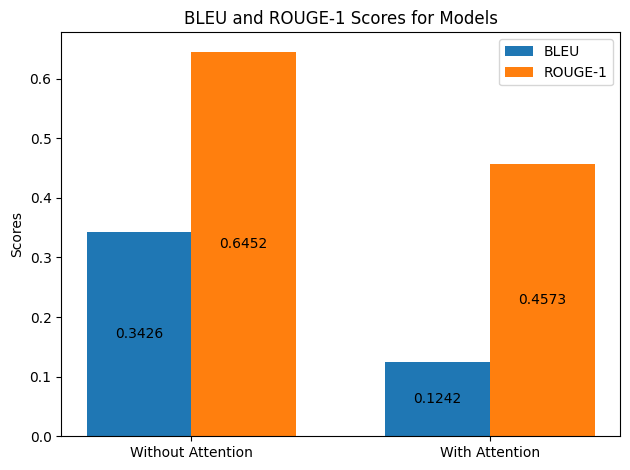

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already calculated the scores as mentioned in the previous response

models = ['Without Attention', 'With Attention']
bleu_scores = [bleu_score_no_attention, bleu_score_with_attention]
rouge_scores = [rouge_score_no_attention, rouge_score_with_attention]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bleu_scores, width, label='BLEU')
rects2 = ax.bar(x + width/2, rouge_scores, width, label='ROUGE-1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('BLEU and ROUGE-1 Scores for Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.bar_label(rects1, labels=[f'{score:.4f}' for score in bleu_scores], label_type='center')
ax.bar_label(rects2, labels=[f'{score:.4f}' for score in rouge_scores], label_type='center')
fig.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Training times in seconds
without_attention_time = 1196.70

# From the log, these are the per-epoch times for "With Attention"
with_attention_times = [63, 81, 82, 60, 83, 81, 60, 83, 81, 60, 83, 81, 81, 81, 82]
with_attention_total = sum(with_attention_times)

# Plotting
models = ['Without Attention', 'With Attention']
times = [without_attention_time, with_attention_total]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, times, color=['skyblue', 'lightcoral'])
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison: With vs Without Attention')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
